# Mask R-CNN - Inspect Brain Tissue Trained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

import brain

%matplotlib inline 

# Directory to save logs and trained model
LOGS_DIR = os.path.join(ROOT_DIR, "logs")

Using TensorFlow backend.


In [2]:
# Comment out to reload imported modules if they change
# %load_ext autoreload
# %autoreload 2

## Configurations

In [12]:
# Dataset directory
DATASET_DIR = os.path.join(ROOT_DIR, "samples/braintissue/datasets/brainseg")

# Inference Configuration
config = brain.BrainsegInferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        600
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                2.0
IMAGE_RESIZE_MODE              pad64
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

## Notebook Preferences

In [13]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# Only inference mode is supported right now
TEST_MODE = "inference"

In [14]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    fig, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    fig.tight_layout()
    return ax

## Loss Model Graphs

In [129]:
path_loss = "run_.-tag-loss.csv"
epoch, value_loss = np.loadtxt(path_loss, delimiter=',', unpack=True, skiprows=1,usecols=(1,2))

path_val_loss = "run_.-tag-val_loss.csv"
epoch, value_val_loss = np.loadtxt(path_val_loss, delimiter=',', unpack=True, skiprows=1,usecols=(1,2))

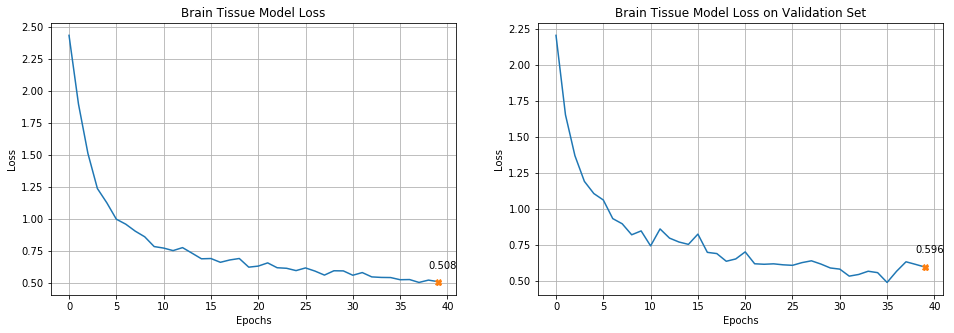

In [154]:
fig, axes = plt.subplots(1,2)
fig.set_size_inches(16,5)


axes[0].plot(epoch, value_loss)
axes[0].set_title("Brain Tissue Model Loss")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].plot(epoch[-1],value_loss[-1], marker='X')
axes[0].text(epoch[-1] - 1,value_loss[-1] + 0.1, f'{value_loss[-1]:.3f}')
axes[0].grid(True)

axes[1].plot(epoch, value_val_loss)
axes[1].set_title("Brain Tissue Model Loss on Validation Set")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].plot(epoch[-1],value_val_loss[-1], marker='X')
axes[1].text(epoch[-1] - 1,value_val_loss[-1] + 0.1, f'{value_val_loss[-1]:.3f}')
axes[1].grid(True)


## Load Validation Dataset

In [36]:
# Load validation dataset
dataset = brain.BrainsegDataset()
dataset.load_brainseg(DATASET_DIR, "stage1_test")
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 53
Classes: ['BG', 'tissue', 'mag']


## Load Model

In [37]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference",
                              model_dir=LOGS_DIR,
                              config=config)

In [38]:
# Path to a specific weights file
# weights_path = "/path/to/mask_rcnn_nucleus.h5"

# Or, load the last model you trained
weights_path = model.find_last()

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /Documents/BrainSegmentation_v1/Mask_RCNN/logs/brainseg20181215T1510/mask_rcnn_brainseg_0040.h5
Re-starting from epoch 40


## Run Detection

image ID: brainseg.artif2_11_crop1 (25) artif2_11_crop1
Original image shape:  [512 512   3]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    6.00000  max:  166.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:    6.00000  max:  166.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.17695  max:    1.11439  float32
gt_class_id              shape: (27,)                 min:    1.00000  max:    2.00000  int32
gt_bbox                  shape: (27, 4)               min:    0.00000  max: 1024.00000  int32
gt_mask                  shape: (1024, 1024, 27)      min:    0.00000  max:    1.00000  bool

Mean Averaged Precision : 0.9259259104728699
Recall : 0.9259259259259259


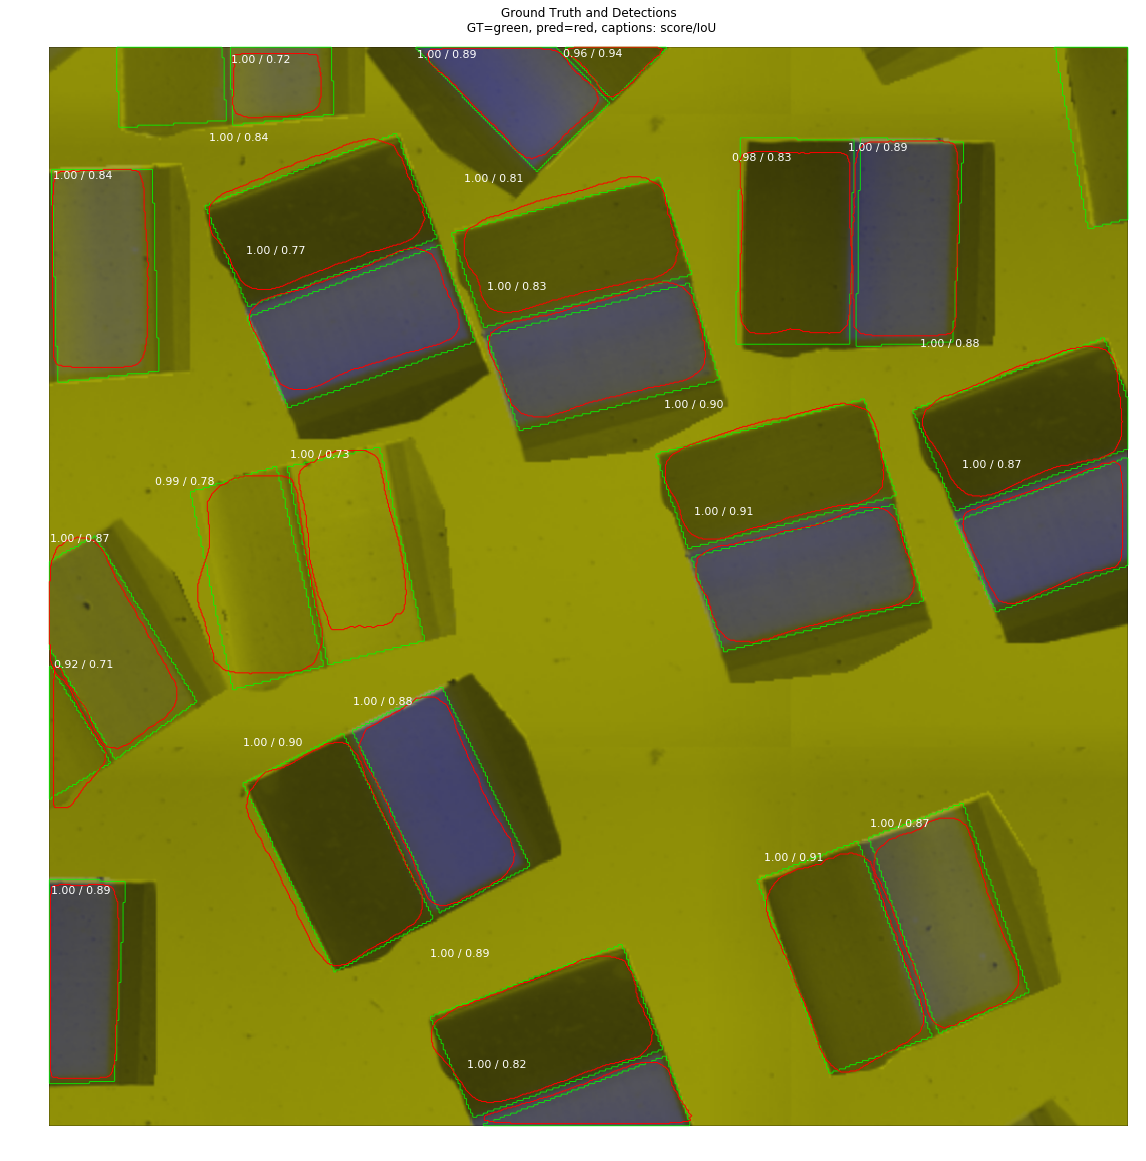

In [50]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
print("Original image shape: ", modellib.parse_image_meta(image_meta[np.newaxis,...])["original_image_shape"][0])

# Run object detection
results = model.detect_molded(np.expand_dims(image, 0), np.expand_dims(image_meta, 0), verbose=1)

# Display results
r = results[0]
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

# Compute AP over range 0.5 to 0.95 and print it
mean_averaged_precision, _, _, _ = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                       r['rois'], r['class_ids'], r['scores'], r['masks'])

recall, _  = utils.compute_recall(r['rois'], gt_bbox, 0.5)

print("\nMean Averaged Precision : {}".format(mean_averaged_precision))
print("Recall : {}".format(recall))

visualize.display_differences(
    image,
    gt_bbox, gt_class_id, gt_mask,
    r['rois'], r['class_ids'], r['scores'], r['masks'],
    dataset.class_names, ax=get_ax(),
    show_box=False, show_mask=False,
    iou_threshold=0.5, score_threshold=0.5)

### Compute AP & Recall on Batch of Images (from Test set)

In [62]:
def compute_batch_ap_recall(dataset, image_ids, verbose=1):
    APs = []
    recalls = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        ap,_,_,_ = utils.compute_ap(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'])
        APs.append(ap)
        
        recall, _  = utils.compute_recall(r['rois'], gt_bbox, 0.5)
        recalls.append(recall)
        
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   AP: {:.3f} / Recall : {:.3f} ".format(
                meta["image_id"][0], meta["original_image_shape"][0], ap,recall))
    return APs, recalls



In [63]:
# Run on test set
APs, recalls = compute_batch_ap_recall(dataset, dataset.image_ids[:])
print("Mean Averaged Precision over all {} test images: {:.4f}".format(len(APs), np.mean(APs)))
print("Mean Recall over all {} test images: {:.4f}".format(len(recalls), np.mean(recalls)))

  0 [512 512   3]   AP: 0.960 / Recall : 0.962 
  1 [1024 1024    3]   AP: 0.588 / Recall : 0.588 
  2 [512 512   3]   AP: 0.878 / Recall : 0.885 
  3 [512 512   3]   AP: 0.870 / Recall : 0.870 
  4 [1024 1024    3]   AP: 0.722 / Recall : 0.722 
  5 [512 512   3]   AP: 0.846 / Recall : 0.846 
  6 [512 512   3]   AP: 0.955 / Recall : 0.958 
  7 [512 512   3]   AP: 0.857 / Recall : 0.857 
  8 [512 512   3]   AP: 0.857 / Recall : 0.893 
  9 [512 512   3]   AP: 0.905 / Recall : 0.905 
 10 [512 512   3]   AP: 0.950 / Recall : 0.950 
 11 [512 512   3]   AP: 0.967 / Recall : 0.967 
 12 [1024 1024    3]   AP: 0.385 / Recall : 0.385 
 13 [512 512   3]   AP: 0.949 / Recall : 0.949 
 14 [512 512   3]   AP: 0.880 / Recall : 0.880 
 15 [512 512   3]   AP: 0.810 / Recall : 0.833 
 16 [512 512   3]   AP: 0.545 / Recall : 0.545 
 17 [512 512   3]   AP: 0.718 / Recall : 0.778 
 18 [512 512   3]   AP: 0.926 / Recall : 0.926 
 19 [1024 1024    3]   AP: 0.667 / Recall : 0.667 
 20 [1024 1024    3]   AP: 0

**Mean Averaged Precision** = 0.8072

**Mean Recall** = 0.8134

## Step by Step Prediction

## Stage 1: Region Proposal Network

The Region Proposal Network (RPN) runs a lightweight binary classifier on a lot of boxes (anchors) over the image and returns object/no-object scores. Anchors with high *objectness* score (positive anchors) are passed to the stage two to be classified.

Often, even positive anchors don't cover objects fully. So the RPN also regresses a refinement (a delta in location and size) to be applied to the anchors to shift it and resize it a bit to the correct boundaries of the object.

### 1.a RPN Targets

The RPN targets are the training values for the RPN. To generate the targets, we start with a grid of anchors that cover the full image at different scales, and then we compute the IoU of the anchors with ground truth object. Positive anchors are those that have an IoU >= 0.7 with any ground truth object, and negative anchors are those that don't cover any object by more than 0.3 IoU. Anchors in between (i.e. cover an object by IoU >= 0.3 but < 0.7) are considered neutral and excluded from training.

To train the RPN regressor, we also compute the shift and resizing needed to make the anchor cover the ground truth object completely.

In [64]:
# Get anchors and convert to pixel coordinates
anchors = model.get_anchors(image.shape)
anchors = utils.denorm_boxes(anchors, image.shape[:2])
log("anchors", anchors)

# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = anchors[positive_anchor_ix]
negative_anchors = anchors[negative_anchor_ix]
neutral_anchors = anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )

anchors                  shape: (261888, 4)           min: -181.00000  max: 1141.00000  int32
target_rpn_match         shape: (261888,)             min:   -1.00000  max:    1.00000  int32
target_rpn_bbox          shape: (64, 4)               min:   -2.60648  max:    3.75000  float64
positive_anchors         shape: (27, 4)               min:  -13.00000  max: 1037.00000  int32
negative_anchors         shape: (37, 4)               min:  -64.00000  max: 1018.00000  int32
neutral anchors          shape: (261824, 4)           min: -181.00000  max: 1141.00000  int32
refined_anchors          shape: (27, 4)               min:    0.00000  max: 1024.00000  float32


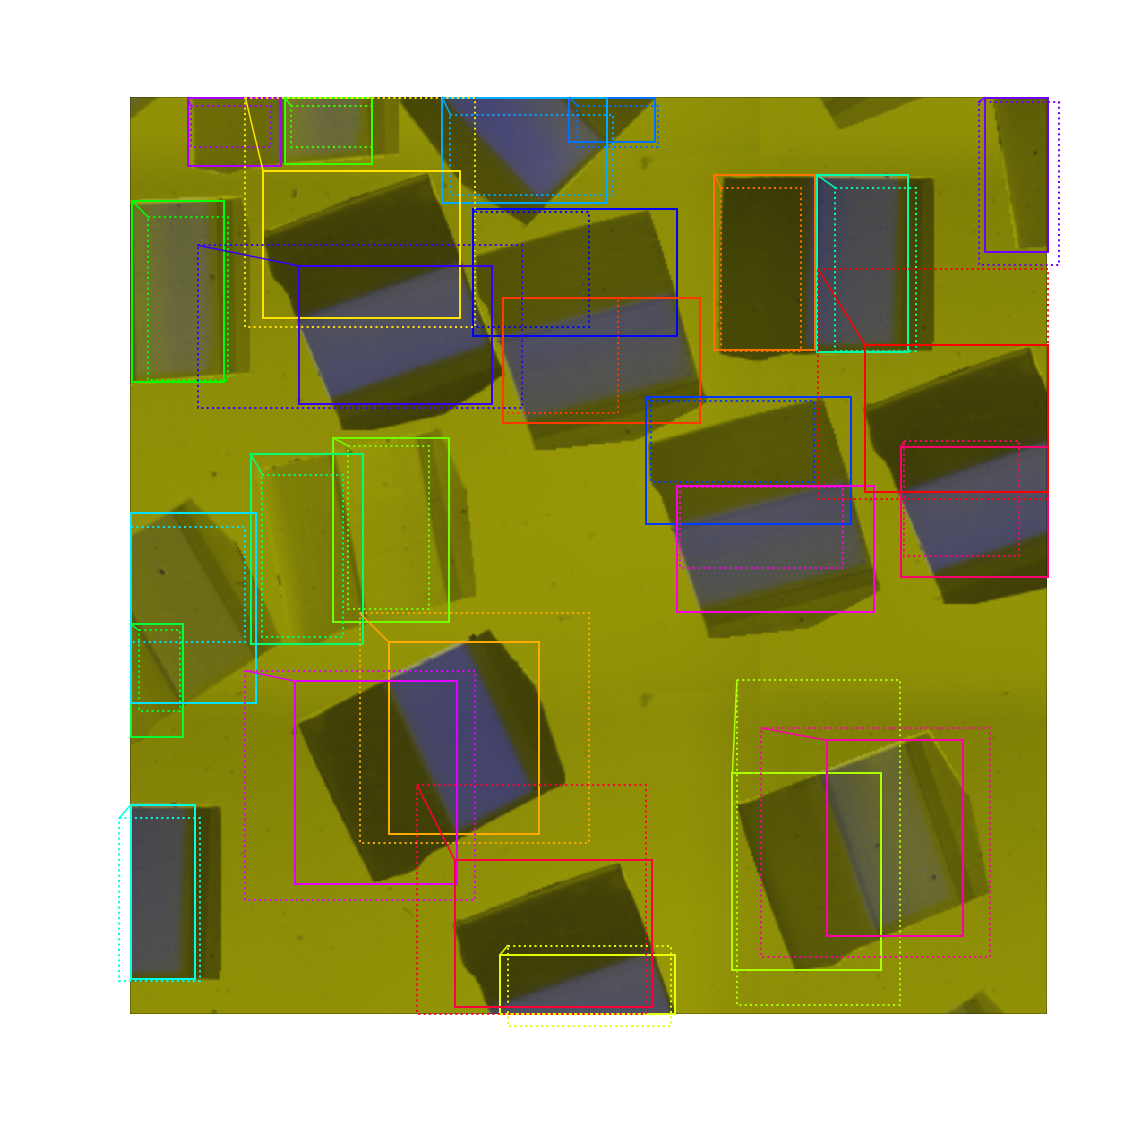

In [65]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(
    image, ax=get_ax(),
    boxes=positive_anchors,
    refined_boxes=refined_anchors)

### 1.b RPN Predictions

Here we run the RPN graph and display its predictions.

In [66]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 and 1.9 introduce new versions of NMS. Search for all names to support TF 1.3~1.10
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")
if nms_node is None: #TF 1.9-1.10
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV3:0")

rpn = model.run_graph(image[np.newaxis], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
], image_metas=image_meta[np.newaxis])

rpn_class                shape: (1, 261888, 2)        min:    0.00000  max:    1.00000  float32
pre_nms_anchors          shape: (1, 6000, 4)          min:   -0.17695  max:    1.11439  float32
refined_anchors          shape: (1, 6000, 4)          min:   -0.17371  max:    1.11852  float32
refined_anchors_clipped  shape: (1, 6000, 4)          min:    0.00000  max:    1.00000  float32
post_nms_anchor_ix       shape: (1024,)               min:    0.00000  max: 2530.00000  int32
proposals                shape: (1, 1024, 4)          min:    0.00000  max:    1.00000  float32


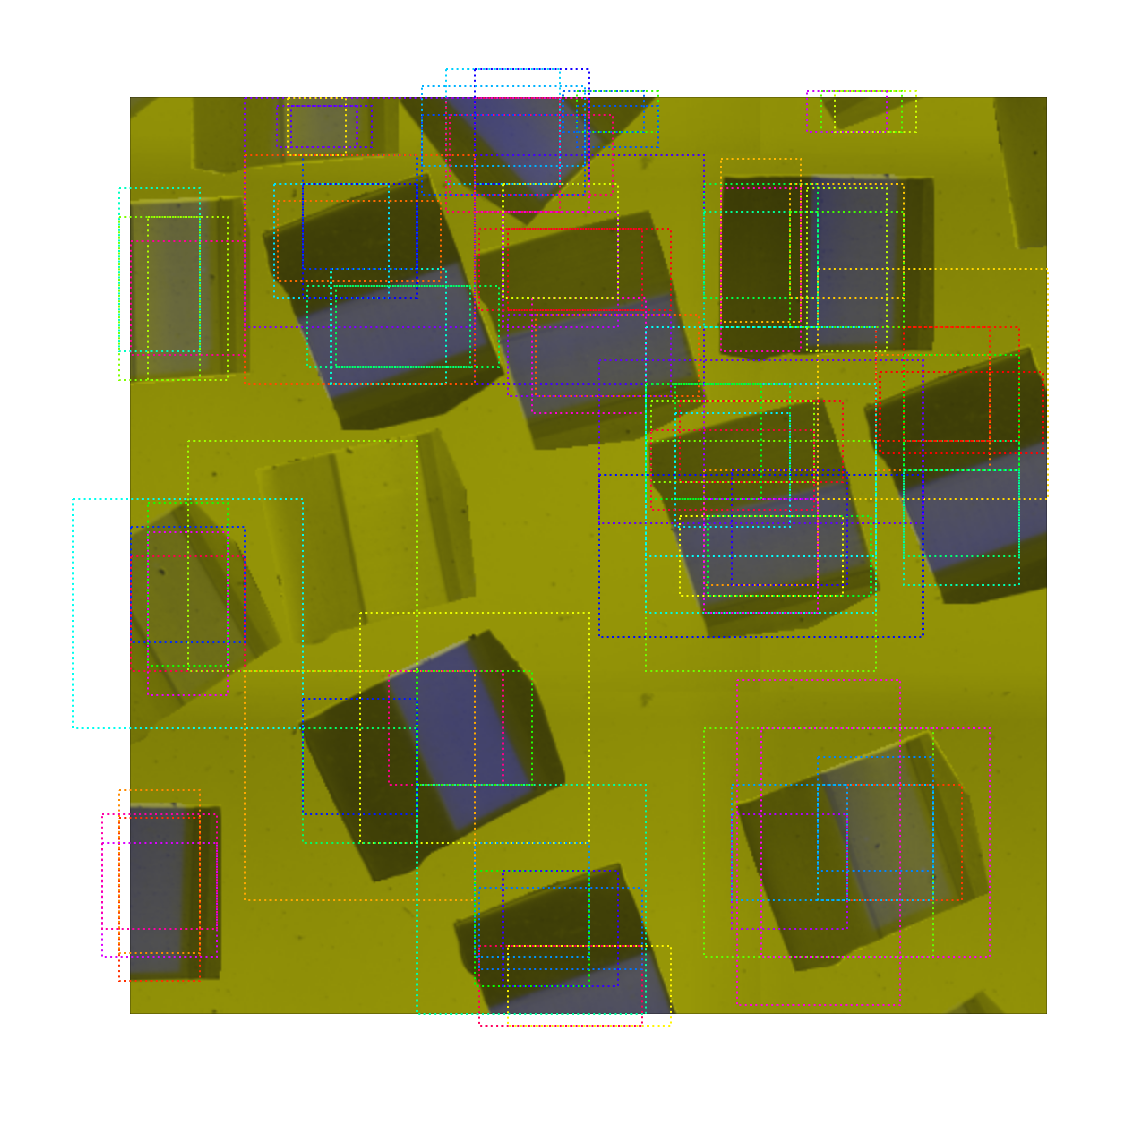

In [67]:
# Show top anchors by score (before refinement)
limit = 100
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=anchors[sorted_anchor_ids[:limit]], ax=get_ax())

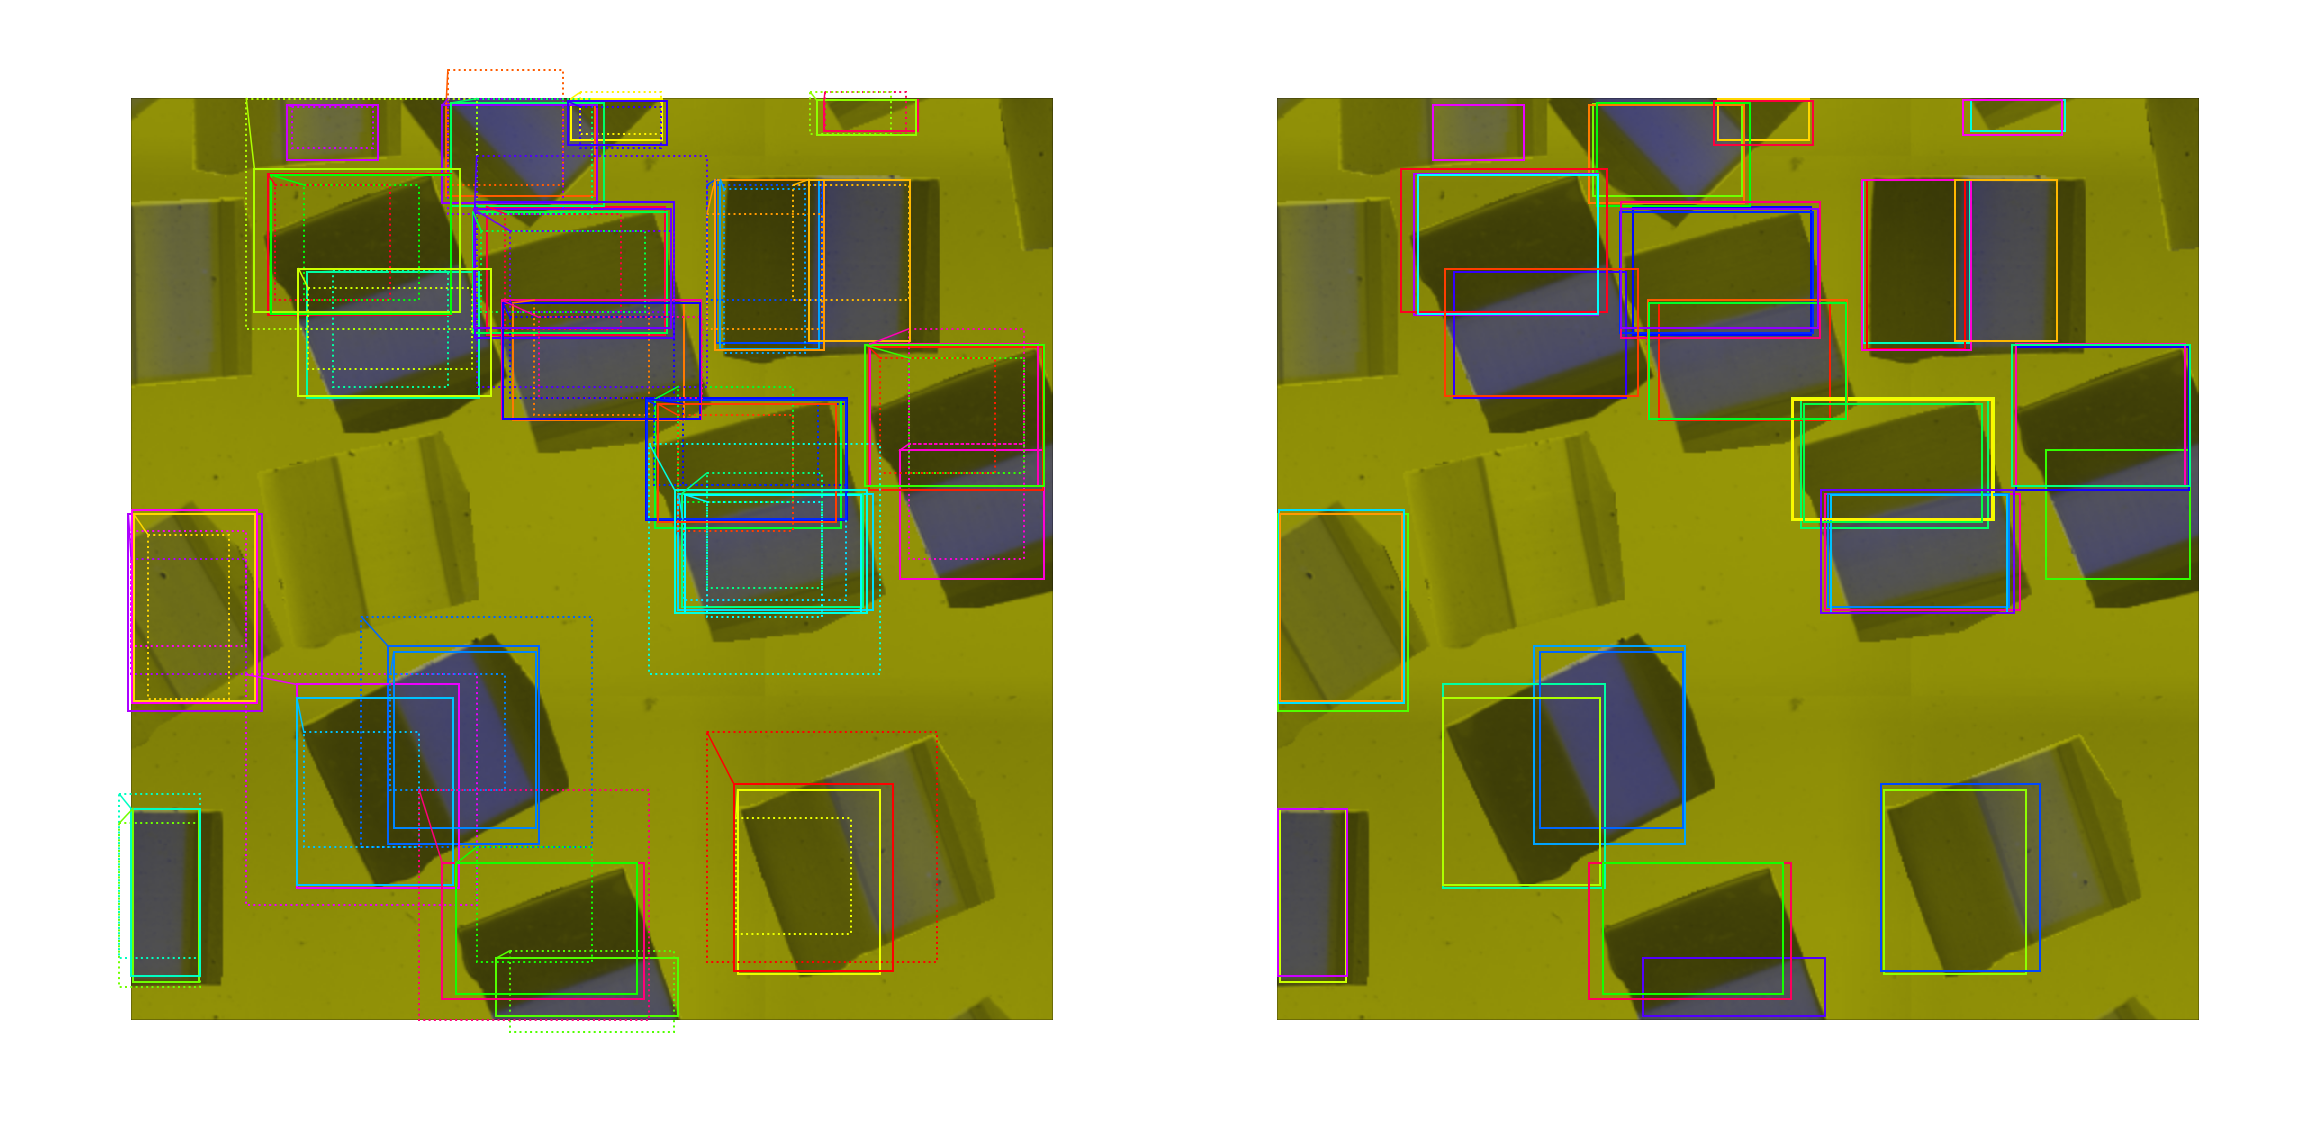

In [68]:
# Show top anchors with refinement. Then with clipping to image boundaries
limit = 50
ax = get_ax(1, 2)
pre_nms_anchors = utils.denorm_boxes(rpn["pre_nms_anchors"][0], image.shape[:2])
refined_anchors = utils.denorm_boxes(rpn["refined_anchors"][0], image.shape[:2])
refined_anchors_clipped = utils.denorm_boxes(rpn["refined_anchors_clipped"][0], image.shape[:2])
visualize.draw_boxes(image, boxes=pre_nms_anchors[:limit],
                     refined_boxes=refined_anchors[:limit], ax=ax[0])
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[:limit], ax=ax[1])

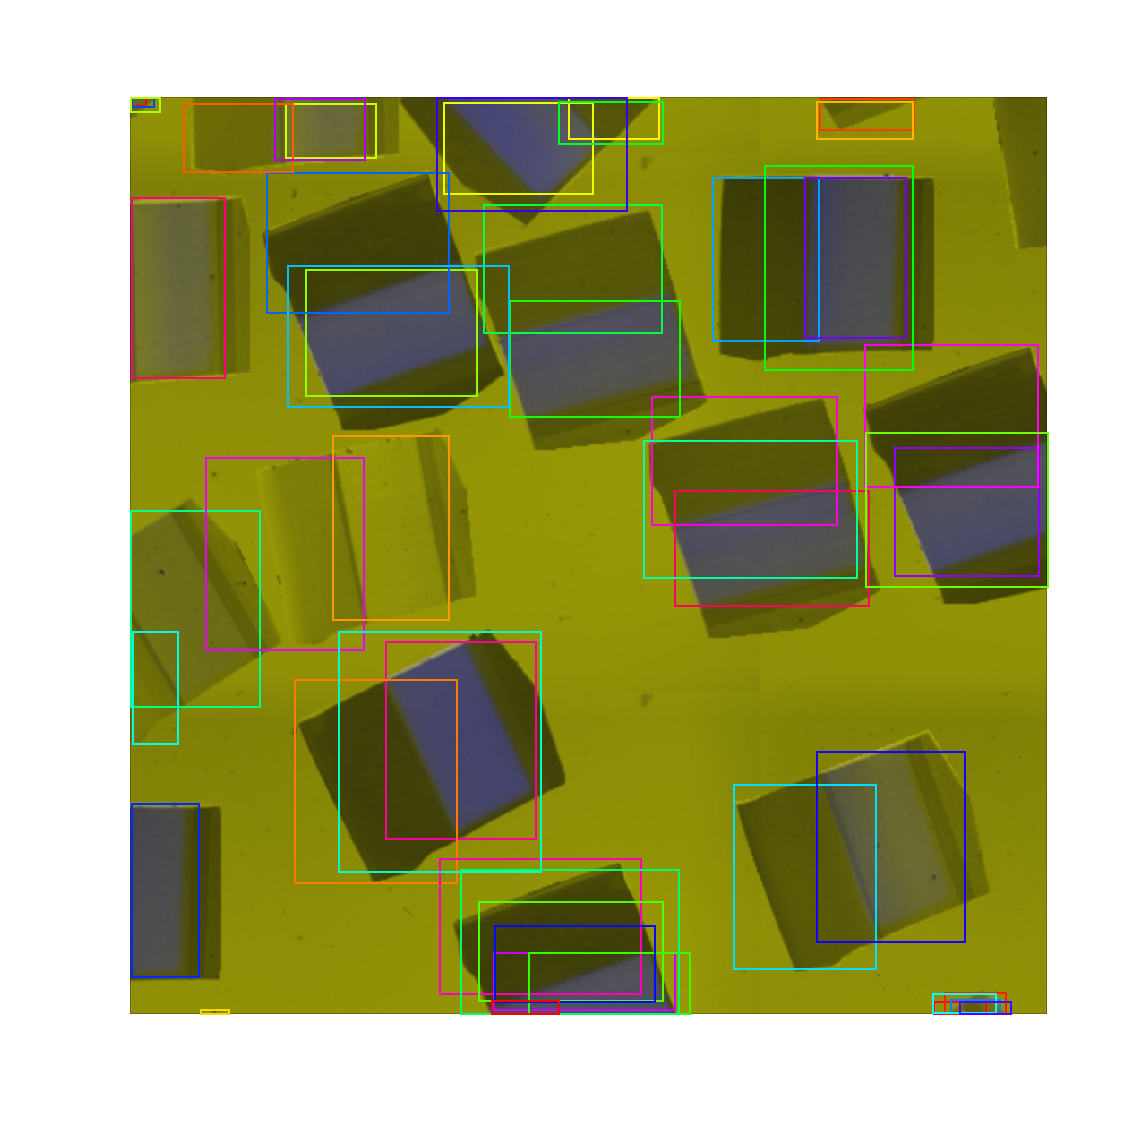

In [69]:
# Show refined anchors after non-max suppression
limit = 50
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[ixs], ax=get_ax())

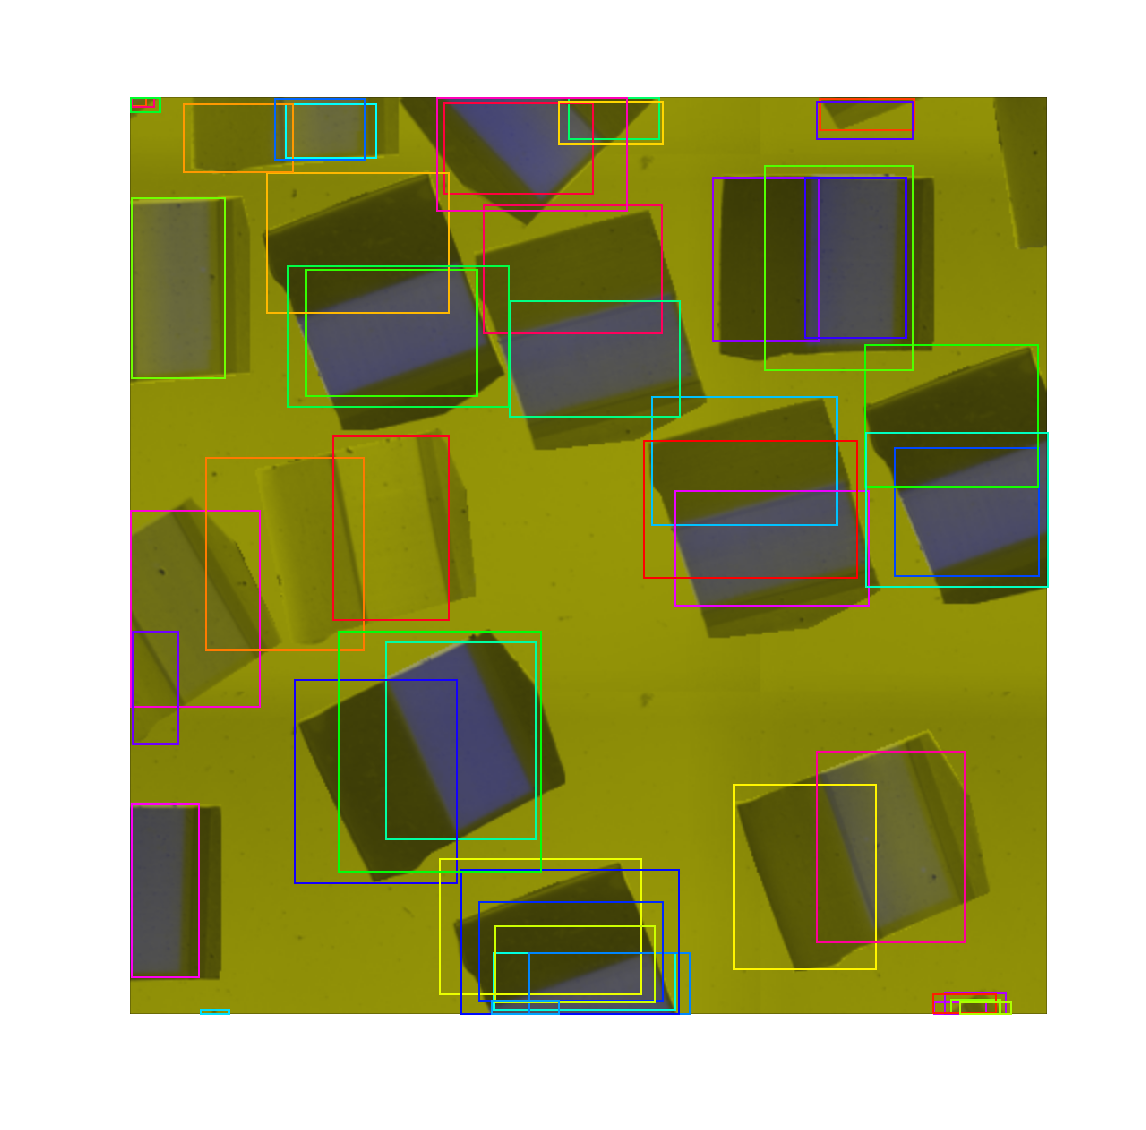

In [70]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 50
# Convert back to image coordinates for display
# h, w = config.IMAGE_SHAPE[:2]
# proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(
    image, ax=get_ax(),
    refined_boxes=utils.denorm_boxes(rpn['proposals'][0, :limit], image.shape[:2]))

## Stage 2: Proposal Classification

This stage takes the region proposals from the RPN and classifies them.

### 2.a Proposal Classification

Run the classifier heads on proposals to generate class propbabilities and bounding box regressions.

In [71]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

proposals                shape: (1, 1024, 4)          min:    0.00000  max:    1.00000  float32
probs                    shape: (1, 1024, 3)          min:    0.00000  max:    1.00000  float32
deltas                   shape: (1, 1024, 3, 4)       min:   -4.38460  max:    3.67874  float32
masks                    shape: (1, 600, 28, 28, 3)   min:    0.00000  max:    1.00000  float32
detections               shape: (1, 600, 6)           min:    0.00000  max:    2.00000  float32


31 detections: ['mag' 'mag' 'mag' 'mag' 'tissue' 'mag' 'mag' 'mag' 'tissue' 'mag'
 'tissue' 'mag' 'mag' 'tissue' 'mag' 'tissue' 'tissue' 'tissue' 'tissue'
 'tissue' 'tissue' 'tissue' 'tissue' 'tissue' 'tissue' 'tissue' 'tissue'
 'mag' 'tissue' 'mag' 'tissue']


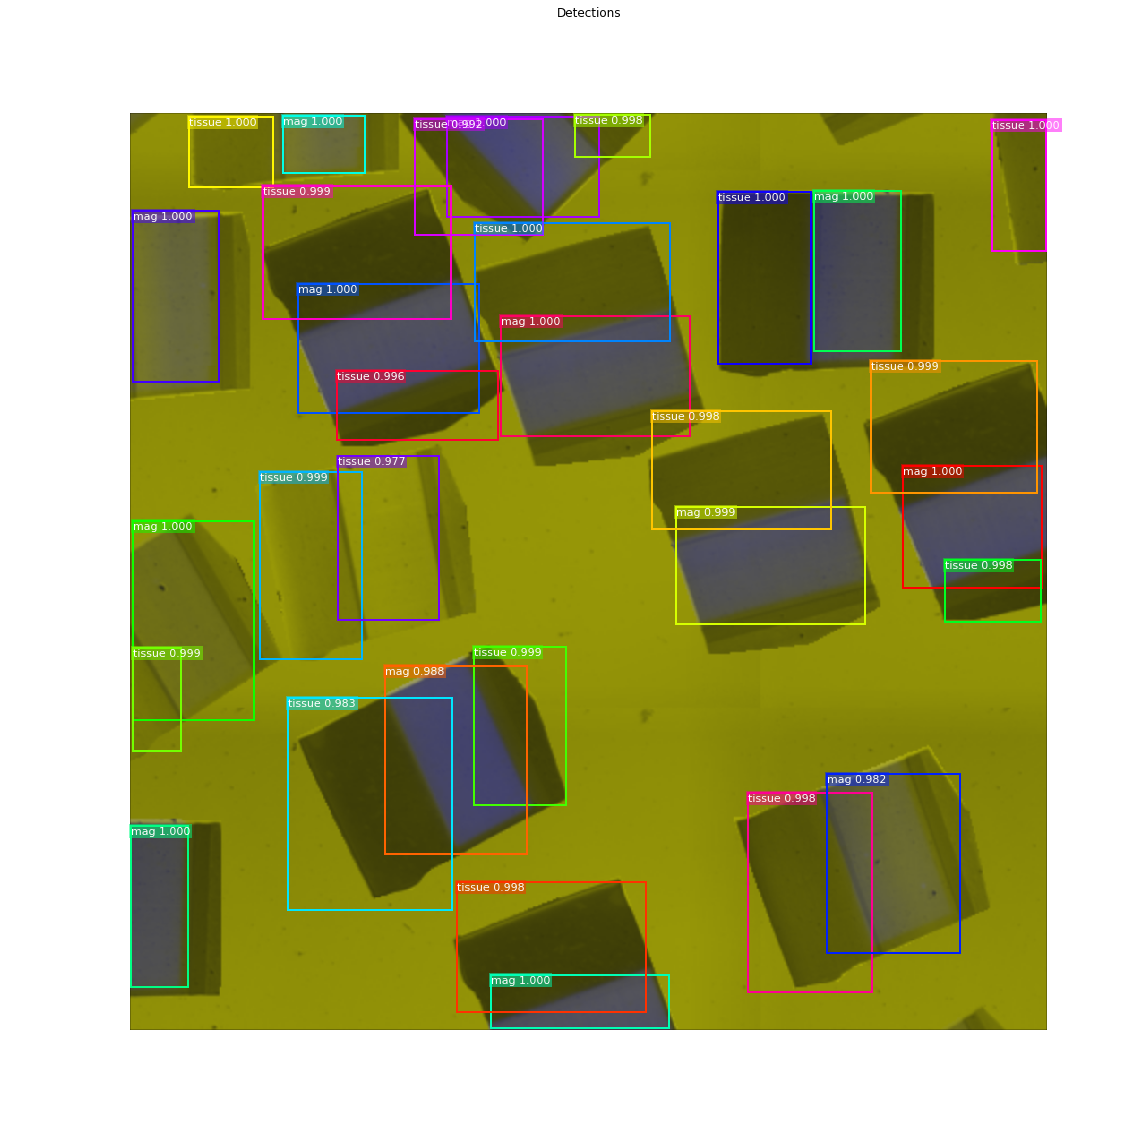

In [72]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
    refined_boxes=utils.denorm_boxes(detections[:, :4], image.shape[:2]),
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

### 2.c Step by Step Detection

Here we dive deeper into the process of processing the detections.

In [73]:
# Proposals are in normalized coordinates
proposals = mrcnn["proposals"][0]

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

1024 Valid proposals out of 1024
123 Positive ROIs
[('BG', 901), ('mag', 52), ('tissue', 71)]


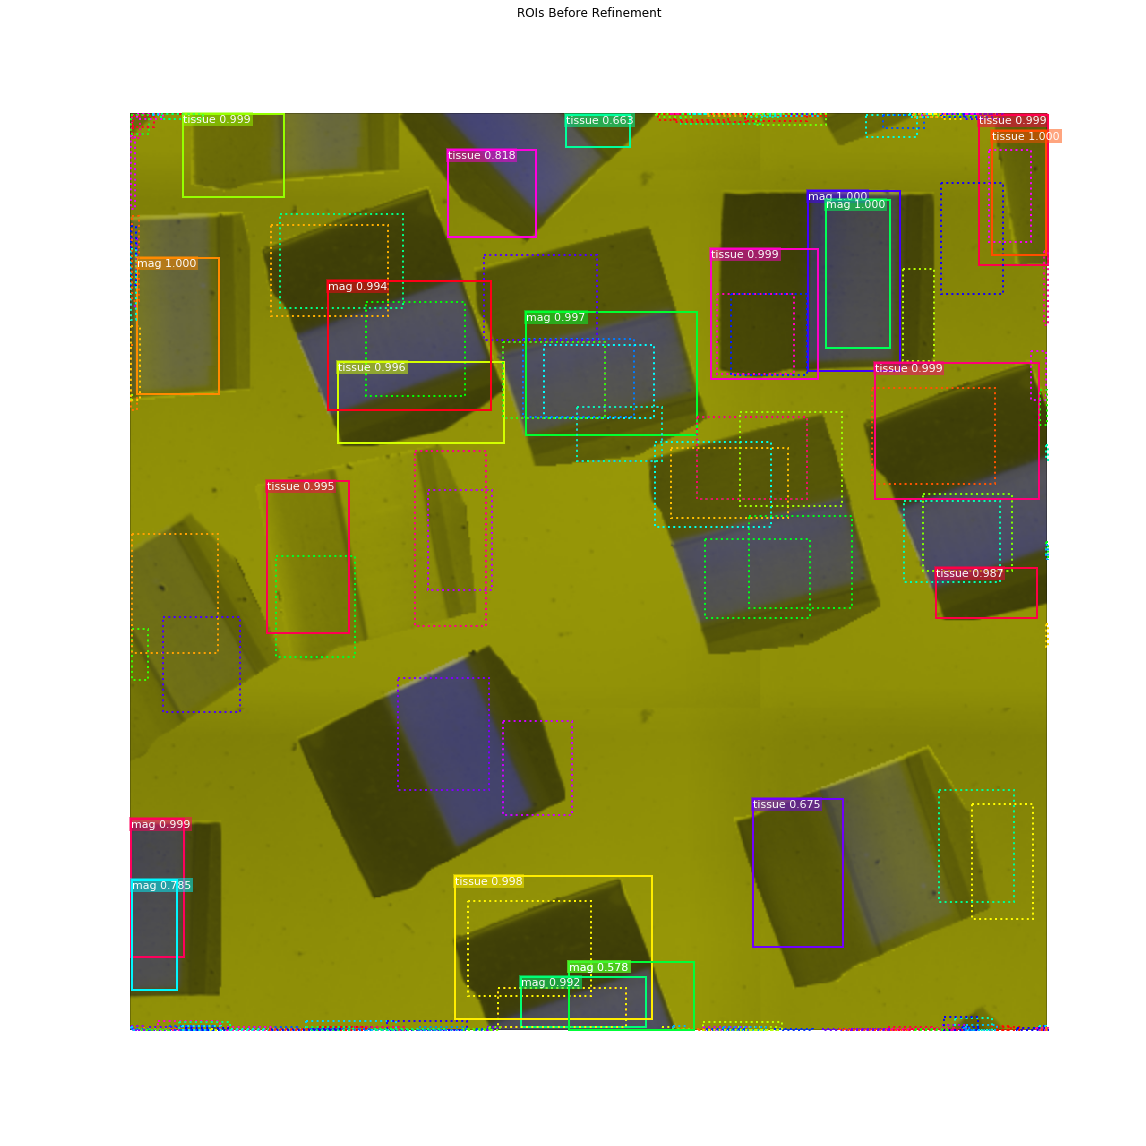

In [74]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 200
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(
    image,
    boxes=utils.denorm_boxes(proposals[ixs], image.shape[:2]),
    visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
    captions=captions, title="ROIs Before Refinement",
    ax=get_ax())

#### Apply Bounding Box Refinement

roi_bbox_specific        shape: (1024, 4)             min:   -3.75364  max:    2.68357  float32
refined_proposals        shape: (1024, 4)             min:   -0.00897  max:    1.00854  float32


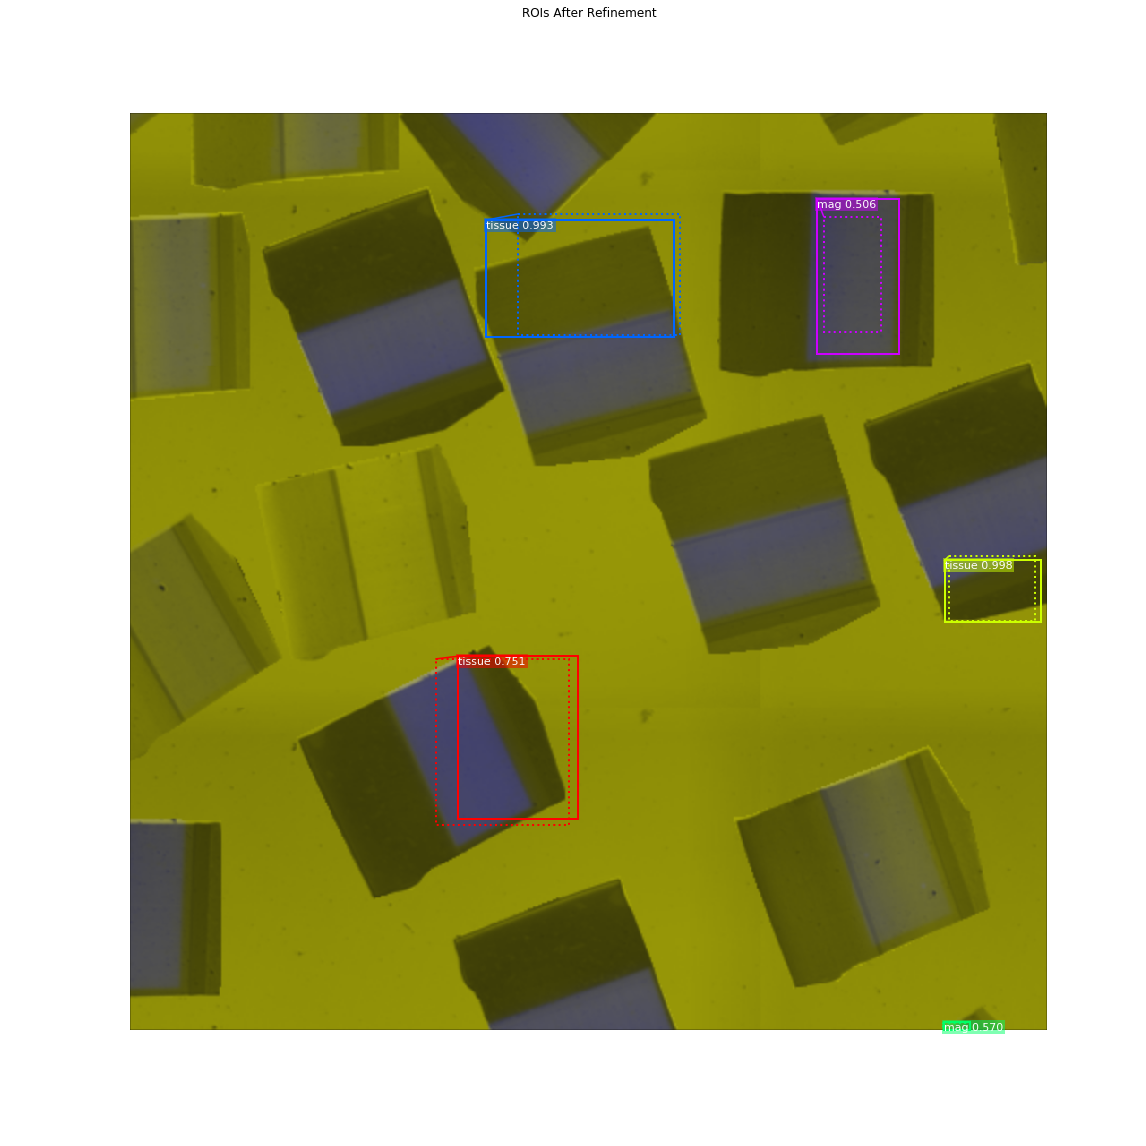

In [75]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 5
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(
    image, ax=get_ax(),
    boxes=utils.denorm_boxes(proposals[roi_positive_ixs][ids], image.shape[:2]),
    refined_boxes=utils.denorm_boxes(refined_proposals[roi_positive_ixs][ids], image.shape[:2]),
    visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
    captions=captions, title="ROIs After Refinement")

#### Filter Low Confidence Detections

In [76]:
# Remove boxes classified as background
keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

Keep 123 detections:
[  0   1   2   3   5   8  19  22  26  49  85  98 101 102 105 110 121 124
 126 129 134 135 138 142 144 146 150 151 152 156 159 160 166 167 168 169
 170 172 175 181 185 188 190 191 192 200 203 207 210 211 218 221 222 224
 233 245 246 247 248 258 263 267 270 272 275 276 279 280 288 291 293 301
 313 318 322 329 343 346 364 401 406 411 445 451 459 463 466 482 495 496
 498 518 538 572 623 628 643 650 651 679 683 712 714 723 724 734 741 746
 772 792 796 816 829 856 869 870 871 920 942 952 979 987 996]


In [77]:
# Remove low confidence detections
keep = np.intersect1d(keep, np.where(roi_scores >= config.DETECTION_MIN_CONFIDENCE)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    config.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))

Remove boxes below 0.9 confidence. Keep 96:
[  0   1   2   3   5   8  19  22  26  85  98 101 102 105 110 121 124 129
 135 138 142 144 146 150 152 156 159 160 167 168 169 170 172 175 181 188
 190 191 192 200 203 207 210 211 218 221 222 224 233 245 247 248 263 267
 270 272 276 279 280 288 291 293 301 313 318 322 329 346 364 401 406 411
 445 451 463 466 482 495 572 623 643 650 651 679 712 723 724 734 772 792
 796 829 869 870 952 979]


#### Per-Class Non-Max Suppression

In [78]:
# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = utils.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            config.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(dataset.class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

tissue                : [  1   2   8  22 101 102 105 124 142 144 146 150 156 159 160 167 169 172
 175 181 190 192 200 210 221 224 245 267 270 272 276 291 301 313 318 322
 346 401 463 466 482 495 572 623 643 650 651 712 723 724 772 829] -> [  8   2 142 159 346 181 146 772 224   1 829 210 101 160 169 172 723 318]
mag                   : [  0   3   5  19  26  85  98 110 121 129 135 138 152 168 170 188 191 203
 207 211 218 222 233 247 248 263 279 280 288 293 329 364 406 411 445 451
 679 734 792 796 869 870 952 979] -> [ 98 110   5   0  19 188 138 191 121 218 203 364 207]

Kept after per-class NMS: 31
[  0   1   2   5   8  19  98 101 110 121 138 142 146 159 160 169 172 181
 188 191 203 207 210 218 224 318 346 364 723 772 829]


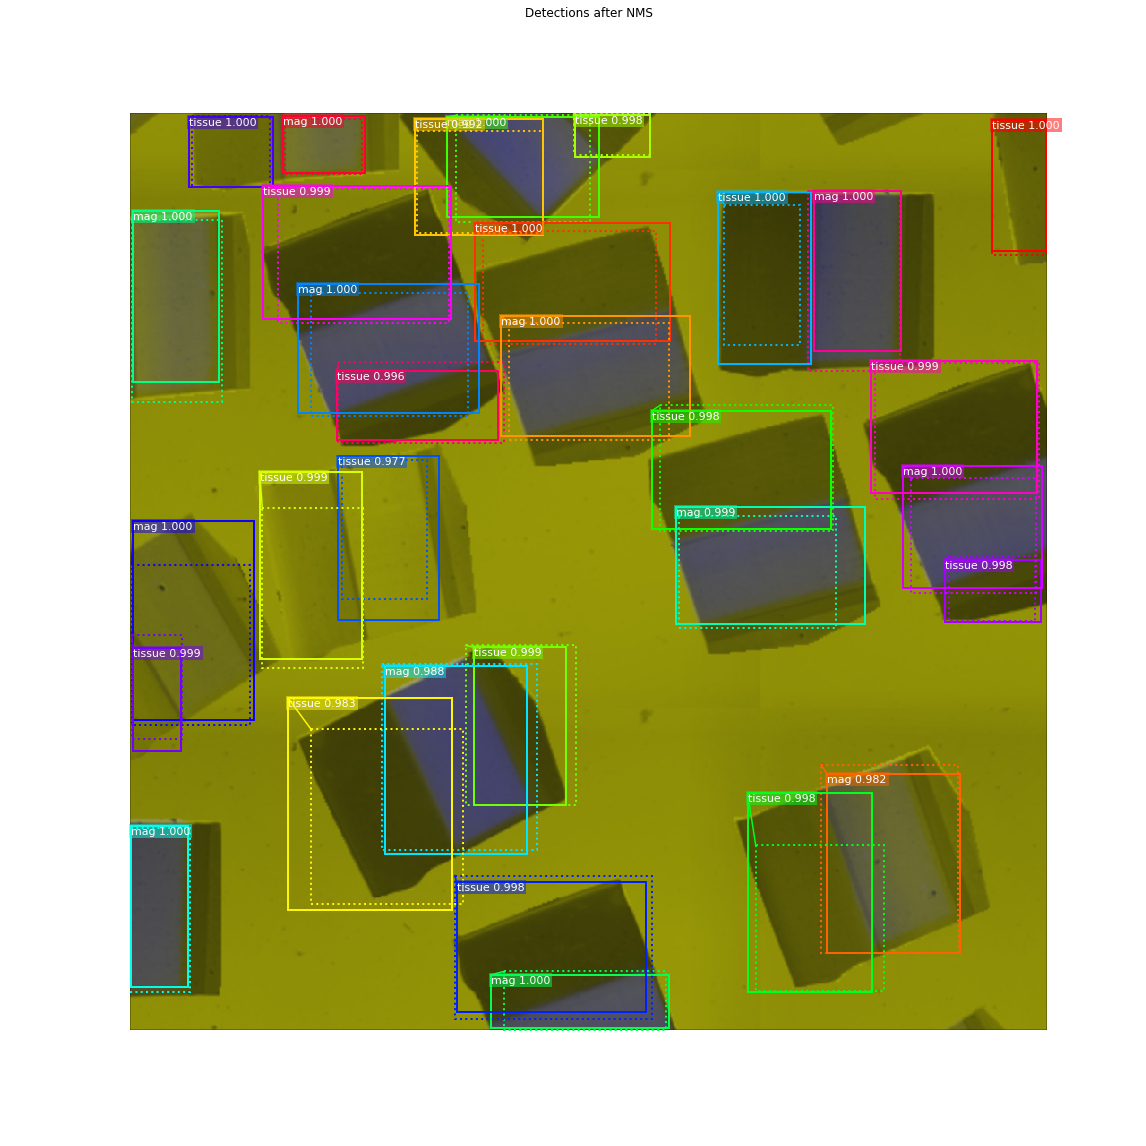

In [79]:
# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image,
    boxes=utils.denorm_boxes(proposals[keep][ixs], image.shape[:2]),
    refined_boxes=utils.denorm_boxes(refined_proposals[keep][ixs], image.shape[:2]),
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

## Stage 3: Generating Masks

This stage takes the detections (refined bounding boxes and class IDs) from the previous layer and runs the mask head to generate segmentation masks for every instance.

### 3.a Mask Targets

These are the training targets for the mask branch

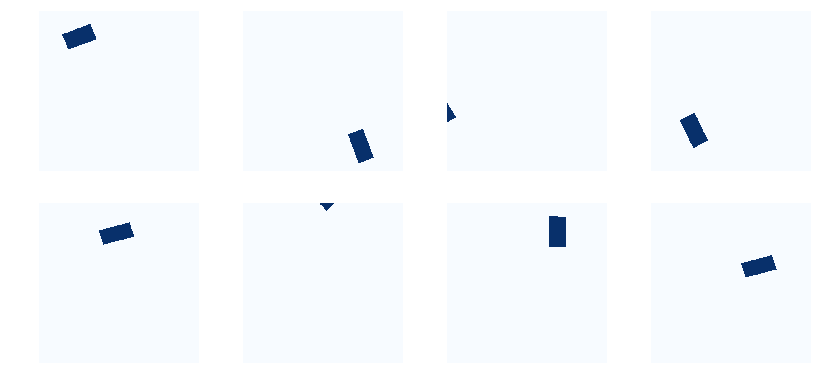

In [80]:
limit = 8
display_images(np.transpose(gt_mask[..., :limit], [2, 0, 1]), cmap="Blues")

### 3.b Predicted Masks

In [81]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

detections               shape: (1, 600, 6)           min:    0.00000  max:    2.00000  float32
masks                    shape: (1, 600, 28, 28, 3)   min:    0.00000  max:    1.00000  float32
31 detections: ['mag' 'mag' 'mag' 'mag' 'tissue' 'mag' 'mag' 'mag' 'tissue' 'mag'
 'tissue' 'mag' 'mag' 'tissue' 'mag' 'tissue' 'tissue' 'tissue' 'tissue'
 'tissue' 'tissue' 'tissue' 'tissue' 'tissue' 'tissue' 'tissue' 'tissue'
 'mag' 'tissue' 'mag' 'tissue']


In [82]:
# Masks
det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

det_mask_specific        shape: (31, 28, 28)          min:    0.00000  max:    1.00000  float32
det_masks                shape: (31, 1024, 1024)      min:    0.00000  max:    1.00000  bool


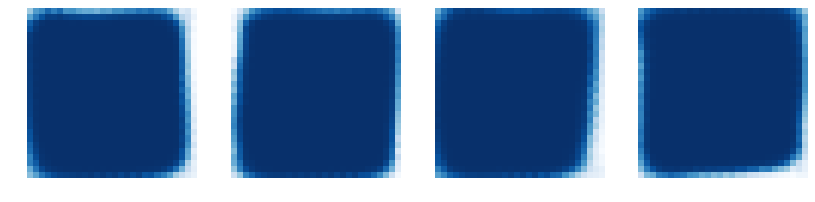

In [83]:
display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")

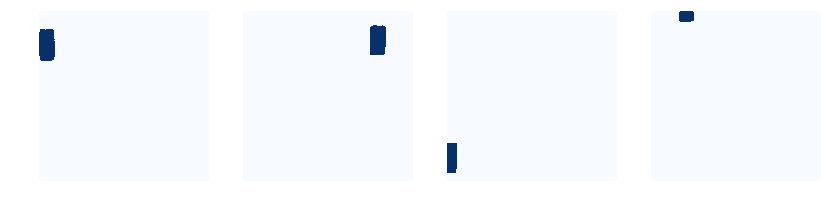

In [84]:
display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none")